# Twin Spar – Modal Analysis (High Input)

**Modal identification via FRF → IRF → LSCE (multi-output)**  
This notebook reproduces the Twin Spar modal analysis from *Dessena et al., Aerospace 2022*, using the **Least Squares Complex Exponential (LSCE)** method.  
Steps:  
1. Load the experimental dataset (XB-2 High Input).  
2. Compute and smooth the Frequency Response Function (FRF).  
3. Transform FRF → IRF via IFFT.  
4. Apply LSCE to identify poles, frequencies, and damping.  
5. Plot the stabilisation diagram.  
6. Extract modal shapes and compare with the reference modes.

## Parameters and Test Setup

General configuration for signal processing and modal identification.  
Frequency range limited to 2.5–98 Hz, as in the paper, to exclude low-frequency noise and high-frequency aliasing.


In [1]:
# Import required scientific packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from scipy.signal import savgol_filter
import scipy.io as sio

# Define main frequency and numerical parameters
F_LOW, F_HIGH = 2.5, 98.0           # Bandpass range [Hz]
SG_ORDER, SG_WIN_DEFAULT = 3, 401   # Savitzky–Golay smoothing
IRF_LEN_MAIN = 8192                 # IRF length
EPS = 1e-12                         # Numerical stability epsilon

# Channel labels (1R–4L = right/left sensors on each spanwise section)
CHANNEL_LABELS = ["1R","1L","2R","2L","3R","3L","4R","4L"]

# Coherence parameters
COH_WINDOW, COH_NPERSEG, COH_NOVERLAP = "hann", 2048, None


## Utility Functions
Helper routines for:
- Butterworth band-pass filtering,  
- Savitzky–Golay smoothing,  
- Coherence computation,  
- LSCE matrix construction.

These functions replicate the numerical pipeline used in Dessena’s study.

In [2]:
def butter_bandpass(x, fs, f1, f2, order=4):
    b, a = signal.butter(order, [f1/(fs/2), f2/(fs/2)], btype="band")
    return signal.filtfilt(b, a, x)

def ensure_sg_window(npos, default_win, order):
    win = min(default_win, npos - (1 - npos % 2))
    if win % 2 == 0: win -= 1
    win = max(win, order + 3)
    if win % 2 == 0: win += 1
    return win

def savgol_complex(y, win, order):
    return savgol_filter(y.real, win, order, mode="interp") + \
           1j * savgol_filter(y.imag, win, order, mode="interp")

def compute_coherence(x, y, fs, nperseg=COH_NPERSEG, noverlap=COH_NOVERLAP, window=COH_WINDOW):
    f, coh = signal.coherence(x, y, fs, nperseg=nperseg, noverlap=noverlap, window=window)
    return f, coh
    
def lsce_once(irf_mat, p, fs):
    n_out, N = irf_mat.shape
    H_blocks, h_blocks = [], []
    for k in range(n_out):
        hsig = irf_mat[k]
        Hk = np.column_stack([hsig[p-1-i:N-1-i] for i in range(p)])
        hk = hsig[p:N]
        H_blocks.append(Hk)
        h_blocks.append(hk)
    H = np.vstack(H_blocks)
    h = np.hstack(h_blocks)
    a, *_ = np.linalg.lstsq(H.astype(np.float32), -h.astype(np.float32), rcond=None)
    poly = np.hstack([1.0, a])
    lmb = np.roots(poly)
    lmb = lmb[(np.abs(lmb) < 1.0) & (np.imag(lmb) > 0)]
    s = (np.log(np.abs(lmb)) + 1j*np.angle(lmb)) * fs
    fn = np.abs(np.imag(s))/(2*np.pi)
    zt = -np.real(s)/(np.abs(s)+1e-12)
    mask = (fn>F_LOW)&(fn<F_HIGH)&(zt>0)&(zt<0.2)
    return fn[mask], zt[mask]


# Load Experimental Data
Dataset `data_xb2.mat` contains:  
- `fs`: sampling frequency,  
- `signal`: [force, accelerometers] for three excitation levels.  
This analysis uses the **High Input** case (`index = 2`).

In [3]:
mat = sio.loadmat("data_xb2.mat")
fs = float(mat["fs"].squeeze())
sig = mat["signal"][:, :, 2]  # High input
x_in = sig[:, 0]
y_out = sig[:, 1:].T


# Pre-processing
# Detrend + band-pass `[F_LOW, F_HIGH]` on input and outputs.

In [4]:
x_in = butter_bandpass(signal.detrend(x_in), fs, F_LOW, F_HIGH)
y_out = np.vstack([butter_bandpass(y_out[i], fs, F_LOW, F_HIGH)
                   for i in range(y_out.shape[0])])

## FRF, phase, coherence
# FRF = `Y/X` in frequency domain. Keep positive half, smooth with Savitzky–Golay filter (order 3, window 401). The magnitude, phase, and coherence are plotted to assess measurement quality. 

In [5]:
X = fft.fft(x_in)
Y = fft.fft(y_out, axis=1)
FRF = Y / (X + EPS*np.max(np.abs(X)))

freqs_full = fft.fftfreq(len(x_in), 1/fs)
mask_pos = freqs_full >= 0
freqs = freqs_full[mask_pos]
FRF_pos = FRF[:, mask_pos]
win = ensure_sg_window(len(freqs), SG_WIN_DEFAULT, SG_ORDER)
FRF_pos_smooth = np.vstack([savgol_complex(FRF_pos[ch], win, SG_ORDER)
                            for ch in range(FRF_pos.shape[0])])
print("Computing coherence...")
coherence_results = []
for ch in range(y_out.shape[0]):
    f_coh, coh = compute_coherence(x_in, y_out[ch], fs)
    coherence_results.append(coh)
coherence_results = np.array(coherence_results)
plt.style.use("seaborn-v0_8-whitegrid")

Computing coherence...


# PLOT FRF MAGNITUDE, PHASE, COHERENCE

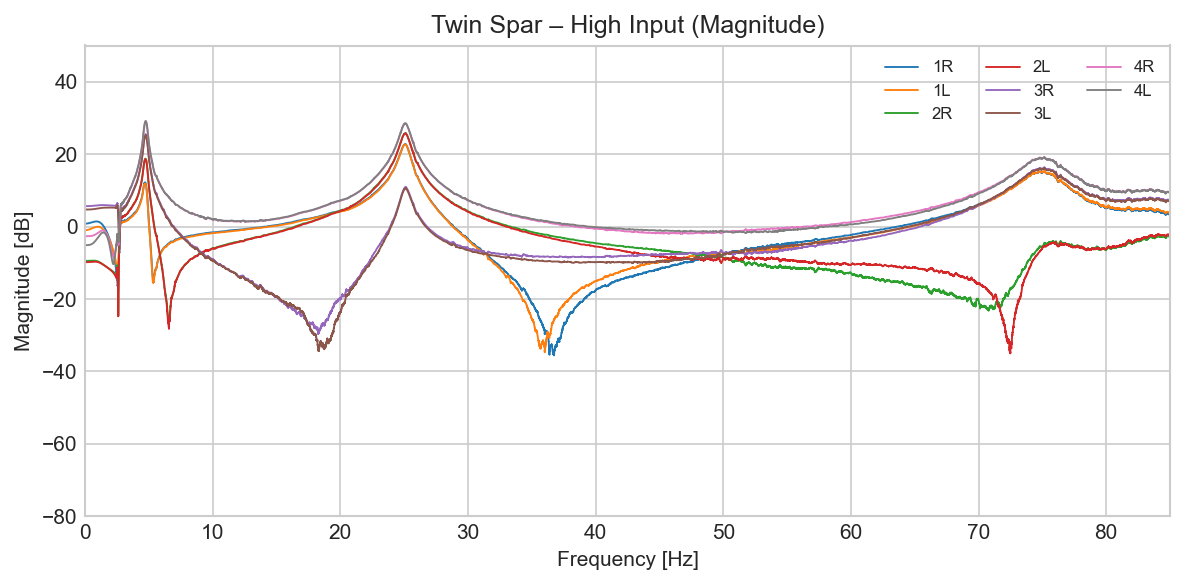

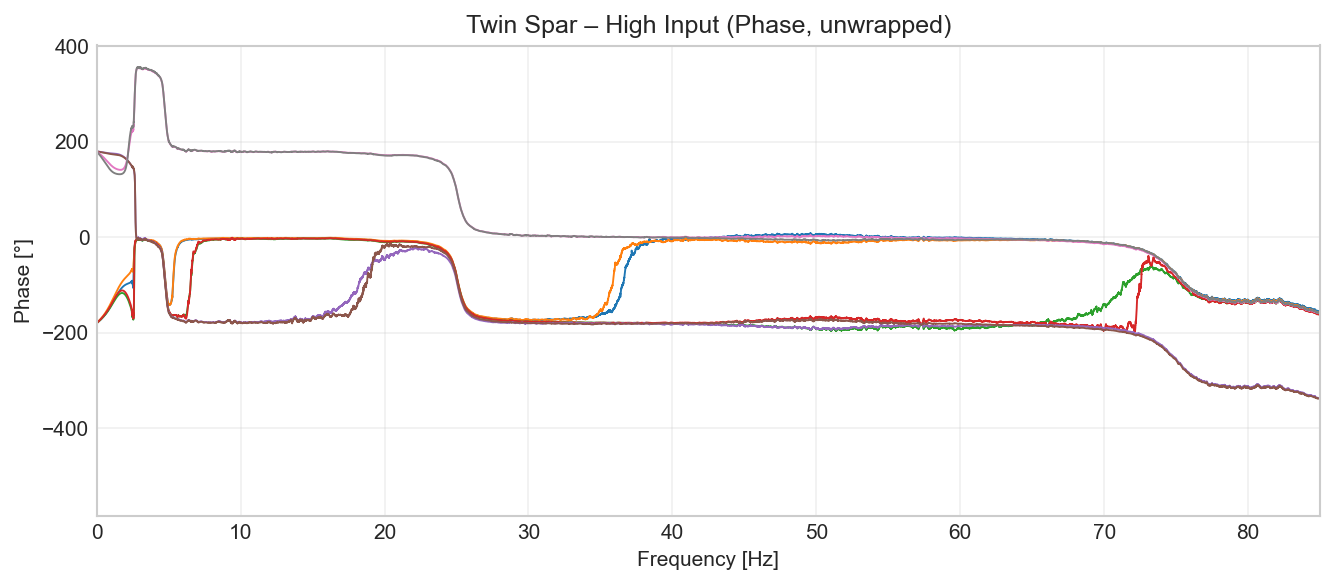

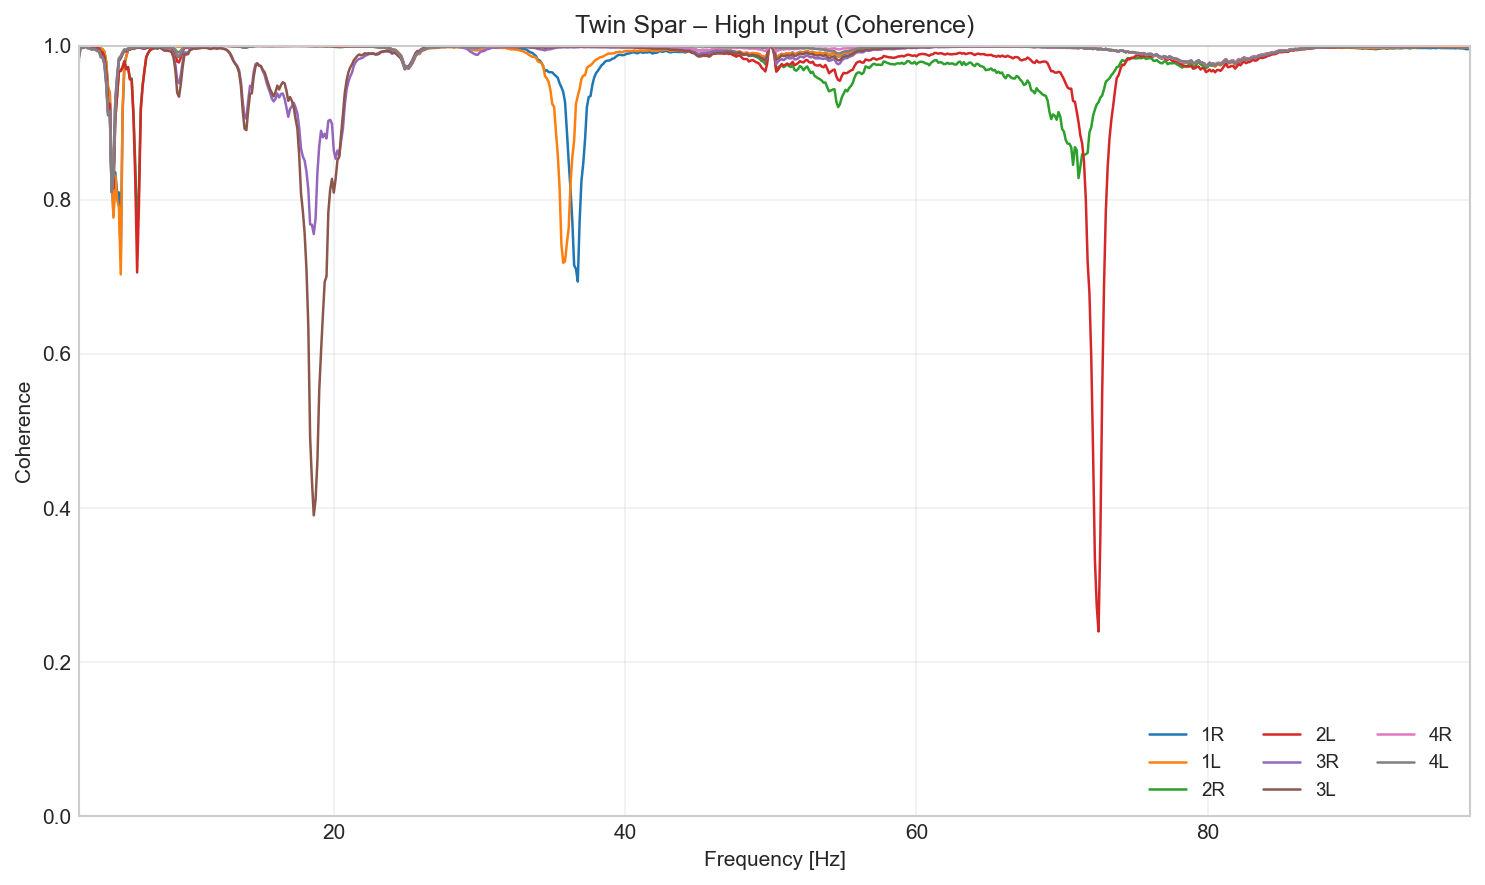

In [ ]:
plt.figure(figsize=(8, 4), dpi=150)

# Magnitude
for ch in range(FRF_pos_smooth.shape[0]):
    mag_db = 20 * np.log10(np.abs(FRF_pos_smooth[ch]) + 1e-18)
    plt.plot(freqs, mag_db, lw=0.9, label=CHANNEL_LABELS[ch])
plt.xlim(0, 85); plt.ylim(-80, 50)
plt.xlabel("Frequency [Hz]"); plt.ylabel("Magnitude [dB]")
plt.title("Twin Spar – High Input (Magnitude)")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout(); plt.show()

# Phase
plt.figure(figsize=(8, 4), dpi=150)
for ch in range(FRF_pos_smooth.shape[0]):
    phase_deg = np.rad2deg(np.unwrap(np.angle(FRF_pos_smooth[ch])))
    plt.plot(freqs, phase_deg, lw=0.9, label=CHANNEL_LABELS[ch])
plt.xlim(0, 85)
plt.xlabel("Frequency [Hz]"); plt.ylabel("Phase [°]")
plt.title("Twin Spar – High Input (Phase, unwrapped)")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Coherence
plt.figure(figsize=(8, 4), dpi=150)
for ch in range(coherence_results.shape[0]):
    plt.plot(f_coh, coherence_results[ch], lw=1.2, label=CHANNEL_LABELS[ch])
plt.xlim(F_LOW, F_HIGH); plt.ylim(0, 1)
plt.xlabel("Frequency [Hz]"); plt.ylabel("Coherence")
plt.title("Twin Spar – High Input (Coherence)")
plt.legend(ncol=3, fontsize=9, loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# IRF Computation (Time Domain)
Impulse Response Function (IRF)
The **Impulse Response Function (IRF)** is obtained by inverse FFT of the smoothed FRF:
This converts the frequency-domain data into a time-domain response suitable for LSCE.

In [7]:
Npos = len(freqs)
Nfull = 2*(Npos-1)
FRF_full = np.zeros((FRF_pos_smooth.shape[0], Nfull), dtype=complex)
FRF_full[:, :Npos] = FRF_pos_smooth
FRF_full[:, Npos:] = FRF_pos_smooth[:, 1:-1][:, ::-1].conj()
IRF = np.real(fft.ifft(FRF_full, axis=1))

# LSCE MULTI-OUTPUT (SIMO).  STABILISATION DIAGRAM
# LSCE Multi-output and Stabilisation Diagram
 
A **stabilisation diagram** is constructed by tracking consistent poles across model orders.  
Stable poles (frequency and damping variation below thresholds) are highlighted.

In [8]:
irf_mat = IRF[:, :IRF_LEN_MAIN]
n_out, N = irf_mat.shape

P_MIN, P_MAX = 4, 36
DF_THR, DZ_THR = 0.01, 0.05

stab_data, stable_pts = [], []
for p in range(P_MIN, P_MAX + 1):
    fn, zt = lsce_once(irf_mat, p, fs)
    stab_data.append((p, fn, zt))
    if p > P_MIN:
        fn_prev, z_prev = stab_data[-2][1], stab_data[-2][2]
        for f, zc in zip(fn, zt):
            if len(fn_prev) == 0: continue
            idx = np.argmin(np.abs(fn_prev - f))
            if abs(fn_prev[idx]-f)/f < DF_THR and abs(z_prev[idx]-zc) < DZ_THR:
                stable_pts.append((p, f, zc))

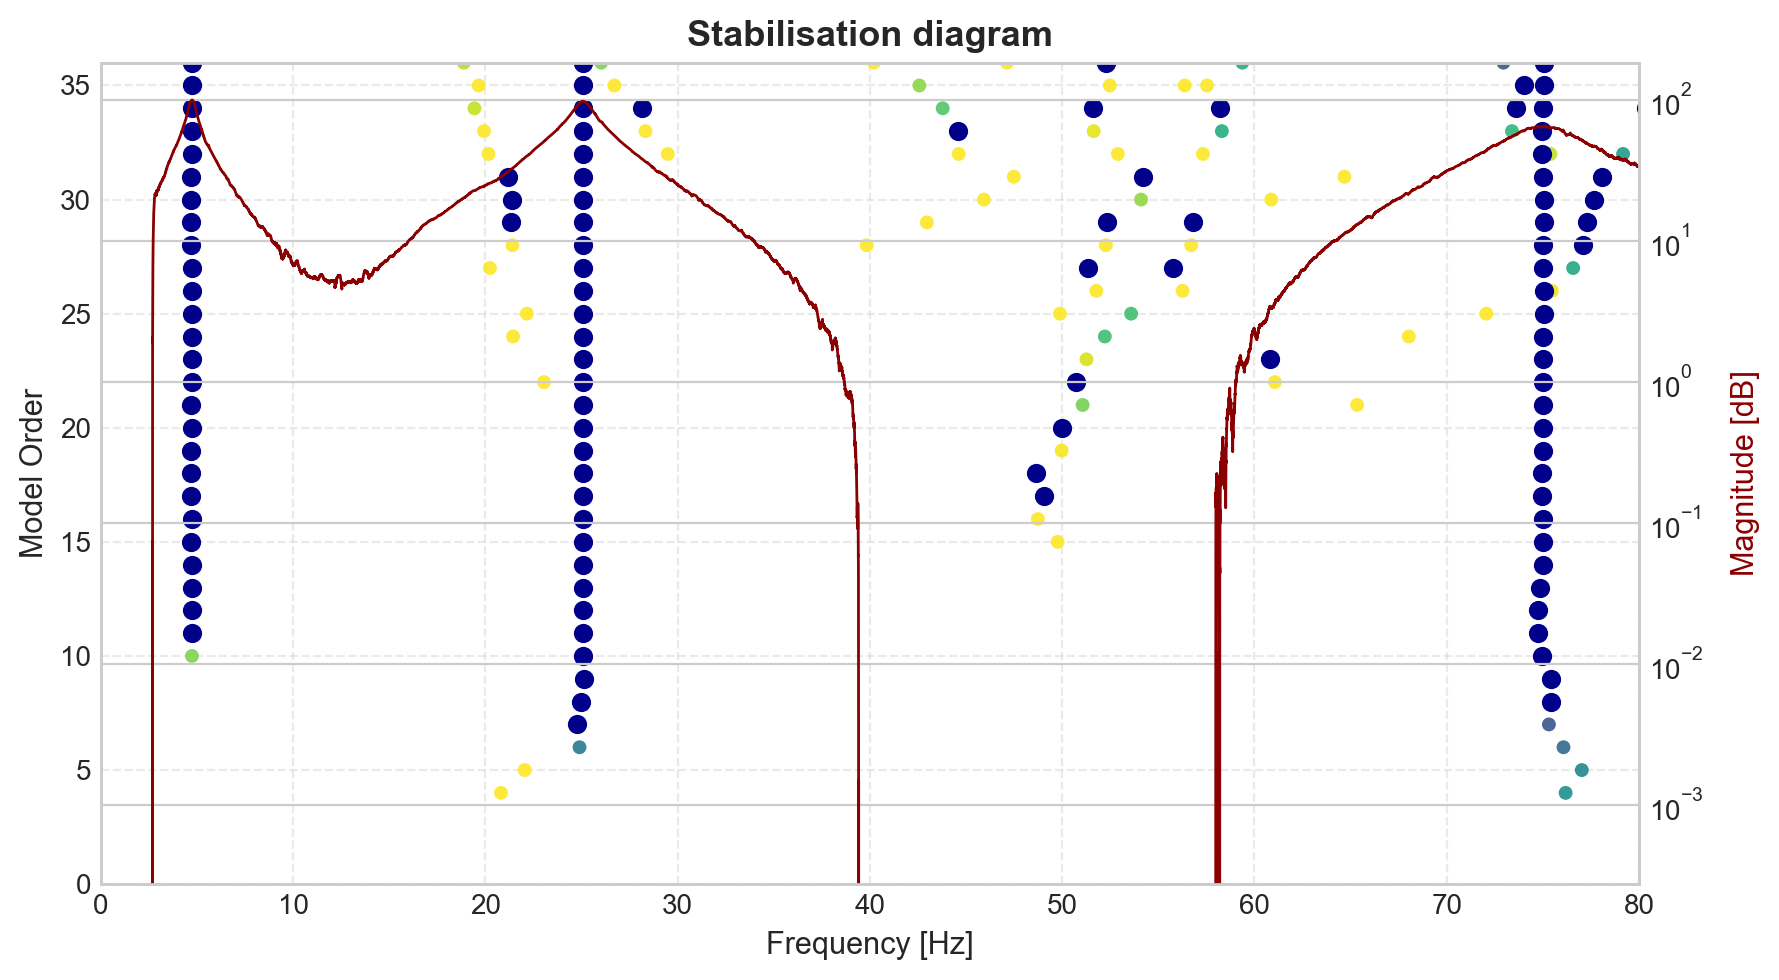

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4), dpi=200)
for p, fn, zt in stab_data:
    ax1.scatter(fn, np.full_like(fn, p), c=zt, s=25, cmap='viridis',
                vmin=0.01, vmax=0.09, edgecolors='none', alpha=0.9)
if stable_pts:
    p_stab = np.array([pt[0] for pt in stable_pts])
    f_stab = np.array([pt[1] for pt in stable_pts])
    ax1.scatter(f_stab, p_stab, color='darkblue', s=35, zorder=3)

ax2 = ax1.twinx()
frf_mag = 20*np.log10(np.abs(FRF_pos_smooth[-1]) + 1e-12)
ax2.plot(freqs, frf_mag/np.max(np.abs(frf_mag))*100, color='darkred', lw=1)
ax2.set_yscale('log')
ax2.set_ylabel("Magnitude [dB]", color='darkred', fontsize=11, labelpad=10)

ax1.set_xlim(0,80)
ax1.set_ylim(0,36)
ax1.set_xlabel("Frequency [Hz]", fontsize=11)
ax1.set_ylabel("Model Order", fontsize=11)
ax1.set_title("Stabilisation diagram", fontsize=13, weight='bold')
ax1.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# OPTIMAL SELECTION AND MODAL SHAPE COMPUTATION.  
From the identified poles:
- natural frequencies \( f_n \) and damping ratios \( \zeta \) are computed,  
- complex modal coefficients (Φ) are extracted via least-squares,  
- phase alignment is performed using the sensors 4R–4L as reference.

In [10]:
p_opt = 32
fn, zt = None, None
for p, fn_tmp, zt_tmp in stab_data:
    if p == p_opt:
        fn, zt = fn_tmp, zt_tmp
        break
if fn is None:
    raise ValueError(f"No poles found for p={p_opt}")

# Reconstruction of full system
n_out, N = irf_mat.shape
H_blocks, h_blocks = [], []
for k in range(n_out):
    hsig = irf_mat[k]
    Hk = np.column_stack([hsig[p_opt-1-i:N-1-i] for i in range(p_opt)])
    hk = hsig[p_opt:N]
    H_blocks.append(Hk)
    h_blocks.append(hk)
H = np.vstack(H_blocks)
h = np.hstack(h_blocks)
a, *_ = np.linalg.lstsq(H.astype(np.float32), -h.astype(np.float32), rcond=None)
poly = np.hstack([1.0, a])
lmb = np.roots(poly)
lmb = lmb[(np.abs(lmb)<1.0) & (np.imag(lmb)>0)]

# Conversion to continuous-time poles
s = (np.log(np.abs(lmb)) + 1j*np.angle(lmb)) * fs
fn_all = np.abs(np.imag(s))/(2*np.pi)
zt_all = -np.real(s)/(np.abs(s)+1e-12)
mask = (fn_all>F_LOW)&(fn_all<F_HIGH)&(zt_all>0)&(zt_all<0.2)
lmb, fn_all, zt_all = lmb[mask], fn_all[mask], zt_all[mask]

# Modal shapes
V = np.vander(lmb, N, increasing=True).T
Phi = np.zeros((n_out, lmb.size), dtype=complex)
for k in range(n_out):
    y = irf_mat[k, :N]
    c, *_ = np.linalg.lstsq(V, y, rcond=None)
    Phi[k, :] = c

# Phase alignment
i4R = CHANNEL_LABELS.index("4R")
i4L = CHANNEL_LABELS.index("4L")
phase_ref = np.angle(0.5 * (Phi[i4R, :] + Phi[i4L, :]))
Phi_al = Phi * np.exp(-1j * phase_ref)[None, :]
Phi_al = Phi_al / np.maximum(np.abs(Phi_al).max(axis=0, keepdims=True), 1e-12)


# MODE FILTERING
Poles are filtered by:
- realistic damping range (0 < ζ < 0.06),  
- proximity (<3%) to FRF peaks,  
- observability at wing tips (4R, 4L).  
Only the first three global modes are retained.

In [11]:
# Mean FRF magnitude (for mode visibility)
mag_avg_db = np.mean(20*np.log10(np.abs(FRF_pos_smooth) + 1e-12), axis=0)
in_band = (freqs >= F_LOW) & (freqs <= F_HIGH)
peaks, props = signal.find_peaks(mag_avg_db[in_band], prominence=6.0)
f_peaks = freqs[in_band][peaks]

idx4R = CHANNEL_LABELS.index("4R")
idx4L = CHANNEL_LABELS.index("4L")

valid_idx = []
for m, (f, z) in enumerate(zip(fn_all, zt_all)):
    if not (0 < z < 0.06):
        continue
    if f_peaks.size:
        rel_df = np.min(np.abs(f_peaks - f)) / f
        if rel_df > 0.03:
            continue
    col = Phi_al[:, m]
    tip_amp = max(abs(col[idx4R]), abs(col[idx4L]))
    max_amp = np.max(np.abs(col))
    if tip_amp < 0.4 * max_amp:
        continue
    valid_idx.append(m)

if len(valid_idx) == 0:
    raise RuntimeError("No valid physical modes found; relax filter thresholds.")

valid_idx = np.array(valid_idx)[np.argsort(fn_all[valid_idx])]
keep = valid_idx[:3] if len(valid_idx) >= 3 else valid_idx

fn_fin = fn_all[keep]
zt_fin = zt_all[keep]
Phi_fin = Phi_al[:, keep]

# Identified Modes and Phase Residuals
Natural frequencies and damping ratios are printed and compared with experimental reference values.  
Residual phase differences across sensors are also shown, confirming proper modal alignment.


In [12]:
idx_4L = CHANNEL_LABELS.index("4L")
print("\n=== Twin Spar – High Input (LSCE multi-output, p_opt=%d) ===" % p_opt)
for i, (f, z) in enumerate(zip(fn_fin, zt_fin), 1):
    print(f"Mode {i}: f_n = {f:.3f} Hz, ζ = {z:.3f}")

print("\n=== Phase residual per mode (after rotation on 4L) ===")
for m, f in enumerate(fn_fin):
    theta = np.angle(Phi_fin[idx_4L, m])
    Phi_rot = Phi_fin[:, m] * np.exp(-1j * theta)
    phi_deg = np.degrees(np.angle(Phi_rot))
    kmax = int(np.argmax(np.abs(phi_deg)))
    print(f"Mode {m+1} ({f:.2f} Hz): max residual = {np.max(np.abs(phi_deg)):.1f}° @ {CHANNEL_LABELS[kmax]}")

targets = np.array([4.738, 25.087, 75.016])
targets1 = np.array([0.029, 0.016, 0.022])
print("\nRelative error f_n [%]:", np.round(np.abs(fn_fin - targets) / targets * 100, 2))
print("Relative error ζ [%]:", np.round(np.abs(zt_fin - targets1) / targets1 * 100, 2))


=== Twin Spar – High Input (LSCE multi-output, p_opt=32) ===
Mode 1: f_n = 4.718 Hz, ζ = 0.030
Mode 2: f_n = 25.072 Hz, ζ = 0.017
Mode 3: f_n = 74.973 Hz, ζ = 0.022

=== Phase residual per mode (after rotation on 4L) ===
Mode 1 (4.72 Hz): max residual = 8.8° @ 1R
Mode 2 (25.07 Hz): max residual = 180.0° @ 3R
Mode 3 (74.97 Hz): max residual = 171.3° @ 3R

Relative error f_n [%]: [0.42 0.06 0.06]
Relative error ζ [%]: [4.08 3.2  0.16]


# MAC COMPARISON 
The identified mode shapes are compared with the reference modes from Table A1.  
The MAC matrix quantifies correlation between estimated and reference modes:
Values close to 1 indicate high correspondence.

In [13]:
Phi_ref = np.array([
    [0.149, 0.550,  0.268],
    [0.141, 0.553,  0.267],
    [0.309, 0.809,  0.069],
    [0.306, 0.806,  0.069],
    [0.664, 0.123, -0.449],
    [0.669, 0.126, -0.423],
    [0.9986,-1.000, 0.965],
    [1.000, -0.997, 1.000],
], dtype=float)

def mac(PhiA, PhiB):
    num = np.abs(PhiA.conj().T @ PhiB)**2
    den = np.outer(np.sum(np.abs(PhiA)**2, axis=0),
                   np.sum(np.abs(PhiB)**2, axis=0))
    return num / np.maximum(den, 1e-15)

idx_4L = CHANNEL_LABELS.index("4L")
phase_ref = np.angle(Phi_fin[idx_4L, :])
Phi_est = Phi_fin * np.exp(-1j*phase_ref)[None, :]

Phi_est = Phi_est / np.linalg.norm(Phi_est, axis=0, keepdims=True)
Phi_ref_n = Phi_ref / np.linalg.norm(Phi_ref, axis=0, keepdims=True)

MAC = mac(Phi_est.real, Phi_ref_n)
diag_mac = np.diag(MAC)
print("\nMAC matrix (est vs paper):\n", np.round(MAC, 3))
print("MAC diagonal:", np.round(diag_mac, 3))


MAC matrix (est vs paper):
 [[0.999 0.122 0.32 ]
 [0.13  0.999 0.306]
 [0.168 0.096 0.904]]
MAC diagonal: [0.999 0.999 0.904]


# MODE SHAPE CONSTRUCTION (Right/Left Separation)
The identified shapes (Φ) are separated into right (R) and left (L) wing halves.  
A root point (φ = 0) is added.  
Each mode is normalised and sign-corrected for visual consistency with the reference shapes.

In [14]:
pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]  # (1R,1L)...(4R,4L)
Phi_R = np.array([Phi_fin[iR, :].real for (iR, _) in pairs])
Phi_L = np.array([Phi_fin[iL, :].real for (_, iL) in pairs])

Phi_R = np.vstack([np.zeros((1, Phi_R.shape[1])), Phi_R])
Phi_L = np.vstack([np.zeros((1, Phi_L.shape[1])), Phi_L])

for m in range(Phi_R.shape[1]):
    max_val = max(np.abs(Phi_R[:, m]).max(), np.abs(Phi_L[:, m]).max())
    Phi_R[:, m] /= max_val
    Phi_L[:, m] /= max_val

for m in range(Phi_R.shape[1]):
    if Phi_R[-1, m] < 0:
        Phi_R[:, m] *= 1
        Phi_L[:, m] *= 1

Phi_R[:, 1] *= -1
Phi_L[:, 1] *= -1

x_coords = np.array([0.0, 0.43, 0.69, 0.875, 1.45])
y_R = np.linspace(0.30, 0.12, len(x_coords))
y_L = -y_R

phi_modes = {
    f"Mode 1 ({fn_fin[0]:.3f} Hz)": (Phi_R[:, 0], Phi_L[:, 0]),
    f"Mode 2 ({fn_fin[1]:.3f} Hz)": (Phi_R[:, 1], Phi_L[:, 1]),
    f"Mode 3 ({fn_fin[2]:.3f} Hz)": (Phi_R[:, 2], Phi_L[:, 2]),
}


# 3D PLOT OF MODAL SHAPE
Each mode is plotted as a 3D deformation of the wing skeleton:  
- Blue: modal displacement,  
- Black: undeformed baseline,  
- Orange: sensor points.  
This reproduces **Figure 10** of *Dessena et al. (2022)*.

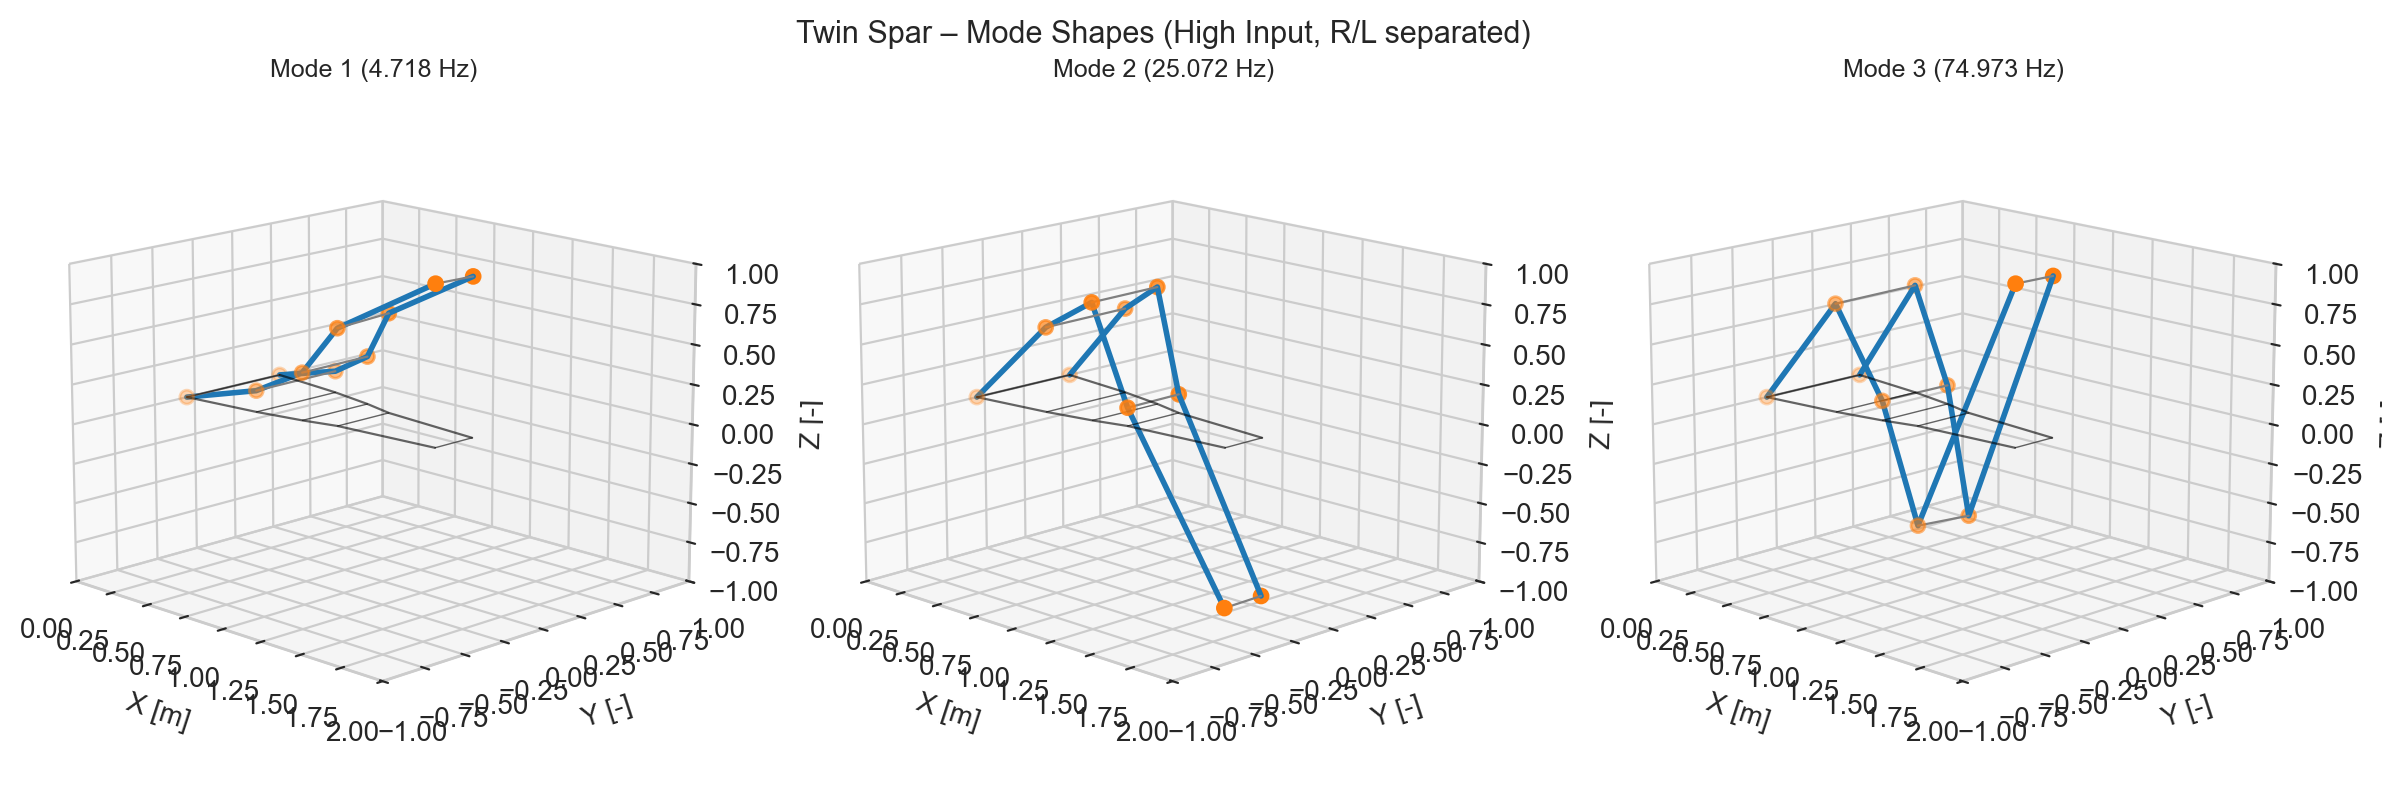

In [15]:

fig = plt.figure(figsize=(12, 4), dpi=200)
for i, (title, (zR, zL)) in enumerate(phi_modes.items(), 1):
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.plot(x_coords, y_R, zR, lw=2, color="tab:blue")
    ax.plot(x_coords, y_L, zL, lw=2, color="tab:blue")

    for j in range(len(x_coords)):
        ax.plot([x_coords[j], x_coords[j]],
                [y_R[j], y_L[j]],
                [zR[j], zL[j]], color="gray", lw=0.8)

    ax.plot(x_coords, y_R, np.zeros_like(x_coords), color="black", lw=0.8, alpha=0.6)
    ax.plot(x_coords, y_L, np.zeros_like(x_coords), color="black", lw=0.8, alpha=0.6)

    for j in range(len(x_coords)):
        ax.plot([x_coords[j], x_coords[j]],
                [y_R[j], y_L[j]],
                [0, 0], color="black", lw=0.5, alpha=0.6)

    ax.scatter(x_coords, y_R, zR, s=25, color="tab:orange")
    ax.scatter(x_coords, y_L, zL, s=25, color="tab:orange")

    ax.set_xlim(0, 2); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [-]"); ax.set_zlabel("Z [-]")
    ax.set_title(title, fontsize=9)
    ax.view_init(elev=15, azim=-45)
    ax.grid(True)

fig.suptitle("Twin Spar – Mode Shapes (High Input, R/L separated)", fontsize=11)
plt.tight_layout()
plt.show()